In [6]:
import os
import random
import csv
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader
from PIL import Image
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, f1_score
import matplotlib.pyplot as plt
import seaborn as sns
import torch.nn.functional as F
import shutil

try:
    os.chdir("/Users/sevvalarslan/projects/SkinDataset")
    print("Çalışma dizini:", os.getcwd())

except FileNotFoundError:
    print("HATA: Belirtilen dizin bulunamadı.")


Çalışma dizini: /Users/sevvalarslan/projects/SkinDataset


In [7]:
src_dirs = ["HAM10000_images_part_1", "HAM10000_images_part_2"]
dst_dir = "all_images"
os.makedirs(dst_dir, exist_ok=True)

for folder in src_dirs:
    folder_path = os.path.join(os.getcwd(), folder)
    for file in os.listdir(folder_path):
        src_path = os.path.join(folder_path, file)
        dst_path = os.path.join(dst_dir, file)
        if not os.path.exists(dst_path):
            shutil.copy(src_path, dst_path)

print(f"Tüm görüntüler toplandı: {len(os.listdir(dst_dir))} adet")


Tüm görüntüler toplandı: 10015 adet


In [8]:
metadata_file = "HAM10000_metadata.csv"
metadata = []

with open(metadata_file, newline="", encoding="utf-8") as f:
    reader = csv.DictReader(f)
    for row in reader:
        metadata.append(row)

print("Metadata satır sayısı:", len(metadata))


Metadata satır sayısı: 10015


In [9]:
label_map = {
    "akiec": 0,
    "bcc": 1,
    "bkl": 2,
    "df": 3,
    "mel": 4,
    "nv": 5,
    "vasc": 6
}

class_names = ["0", "1", "2", "3", "4", "5", "6"] 
data_list = []

for item in metadata:
    img_id = item["image_id"]
    label = label_map[item["dx"]]
    img_path = os.path.join(dst_dir, img_id + ".jpg")

    if os.path.exists(img_path):
        data_list.append((img_path, label))

print(f"Kullanılabilir görüntü sayısı: {len(data_list)}")


Kullanılabilir görüntü sayısı: 10015


In [10]:
class_groups = {i: [] for i in range(7)}
for path, label in data_list:
    class_groups[label].append((path, label))

train_list, val_list, test_list = [], [], []

for label, items in class_groups.items():
    random.shuffle(items)
    n = len(items)
    test_n = max(int(n * 0.15), 1)
    val_n = max(int(n * 0.15), 1)
    test_list.extend(items[:test_n])
    val_list.extend(items[test_n:test_n+val_n])
    train_list.extend(items[test_n+val_n:])

random.shuffle(train_list)
random.shuffle(val_list)
random.shuffle(test_list)

print(f"Train: {len(train_list)}, Val: {len(val_list)}, Test: {len(test_list)}")


Train: 7017, Val: 1499, Test: 1499


In [11]:
IMG_SIZE = 128

train_transform = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ToTensor(),
    transforms.Normalize([0.5]*3, [0.5]*3)
])

val_test_transform = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize([0.5]*3, [0.5]*3)
])

class SkinDataset(Dataset):
    def __init__(self, data_list, transform=None):
        self.data_list = data_list
        self.transform = transform

    def __len__(self):
        return len(self.data_list)

    def __getitem__(self, idx):
        img_path, label = self.data_list[idx]
        image = Image.open(img_path).convert("RGB")
        if self.transform:
            image = self.transform(image)
        return image, label


In [12]:
train_dataset = SkinDataset(train_list, transform=train_transform)
val_dataset = SkinDataset(val_list, transform=val_test_transform)
test_dataset = SkinDataset(test_list, transform=val_test_transform)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

print("DataLoader hazır!")


DataLoader hazır!


In [13]:
class SkinClassifierBase(nn.Module):
    def __init__(self):
        super(SkinClassifierBase, self).__init__()

        self.conv = nn.Conv2d(3, 16, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(2)

        flat_dim = 16 * (IMG_SIZE // 2) * (IMG_SIZE // 2)

        self.fc1 = nn.Linear(flat_dim, 128)
        self.fc2 = nn.Linear(128, 7)

    def forward(self, x):
        x = F.relu(self.conv(x))
        x = self.pool(x)
        x = torch.flatten(x, 1)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x


In [14]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = SkinClassifierBase().to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)


In [15]:
def train_epoch():
    model.train()
    total_loss = 0
    all_preds, all_labels = [], []

    for X, y in train_loader:
        X, y = X.to(device), y.to(device)
        optimizer.zero_grad()
        outputs = model(X)
        loss = criterion(outputs, y)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
        preds = outputs.argmax(dim=1)
        all_preds.extend(preds.cpu())
        all_labels.extend(y.cpu())

    acc = accuracy_score(all_labels, all_preds)
    f1 = f1_score(all_labels, all_preds, average="macro")
    return total_loss / len(train_loader), acc, f1


def eval_epoch(loader):
    model.eval()
    all_preds, all_labels = [], []

    with torch.no_grad():
        for X, y in loader:
            X, y = X.to(device), y.to(device)
            outputs = model(X)
            preds = outputs.argmax(dim=1)
            all_preds.extend(preds.cpu())
            all_labels.extend(y.cpu())

    acc = accuracy_score(all_labels, all_preds)
    f1 = f1_score(all_labels, all_preds, average="macro", zero_division=0)
    return acc, f1


In [16]:
EPOCHS = 10
train_losses, train_accs, val_accs = [], [], []

for epoch in range(1, EPOCHS + 1):
    train_loss, train_acc, train_f1 = train_epoch()
    val_acc, val_f1 = eval_epoch(val_loader)
    train_losses.append(train_loss)
    train_accs.append(train_acc)
    val_accs.append(val_acc)

    print(f"Epoch {epoch:02}/{EPOCHS} | "
          f"Train Loss: {train_loss:8.4f} | "
          f"Train Acc: {train_acc:6.4f} | "
          f"Train F1: {train_f1:6.4f} | "
          f"Val Acc: {val_acc:6.4f} | "
          f"Val F1: {val_f1:6.4f}")
    print("-" * 80)


Epoch 01/10 | Train Loss:   1.0934 | Train Acc: 0.6674 | Train F1: 0.2195 | Val Acc: 0.7085 | Val F1: 0.2483
--------------------------------------------------------------------------------
Epoch 02/10 | Train Loss:   0.8202 | Train Acc: 0.6994 | Train F1: 0.2684 | Val Acc: 0.7231 | Val F1: 0.3297
--------------------------------------------------------------------------------
Epoch 03/10 | Train Loss:   0.7763 | Train Acc: 0.7126 | Train F1: 0.3270 | Val Acc: 0.7218 | Val F1: 0.3067
--------------------------------------------------------------------------------
Epoch 04/10 | Train Loss:   0.7452 | Train Acc: 0.7248 | Train F1: 0.3835 | Val Acc: 0.7278 | Val F1: 0.3621
--------------------------------------------------------------------------------
Epoch 05/10 | Train Loss:   0.7141 | Train Acc: 0.7338 | Train F1: 0.4149 | Val Acc: 0.7325 | Val F1: 0.3965
--------------------------------------------------------------------------------
Epoch 06/10 | Train Loss:   0.7067 | Train Acc: 0.

In [17]:
test_acc, test_f1 = eval_epoch(test_loader)
print("TEST Accuracy:", test_acc)
print("TEST F1:", test_f1)


TEST Accuracy: 0.7451634422948632
TEST F1: 0.48278190529699155


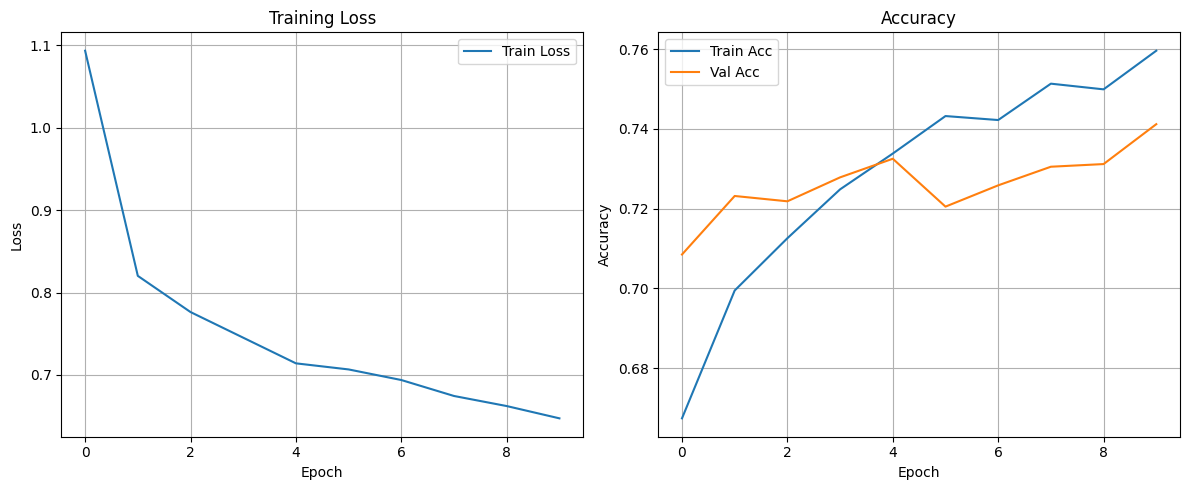

In [18]:
def plot_training_curves():
    plt.figure(figsize=(12,5))

    plt.subplot(1,2,1)
    plt.plot(train_losses, label="Train Loss")
    plt.title("Training Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.grid()
    plt.legend()

    plt.subplot(1,2,2)
    plt.plot(train_accs, label="Train Acc")
    plt.plot(val_accs, label="Val Acc")
    plt.title("Accuracy")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.grid()
    plt.legend()

    plt.tight_layout()
    plt.show()

plot_training_curves()


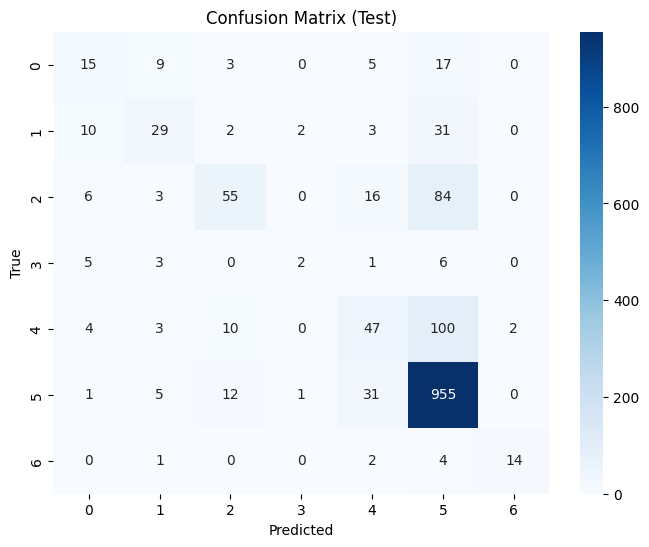

In [22]:
def plot_confusion_matrix_only():
    model.eval()
    all_preds, all_labels = [], []

    with torch.no_grad():
        for X, y in test_loader:
            X, y = X.to(device), y.to(device)
            preds = model(X).argmax(dim=1)
            all_preds.extend(preds.cpu().tolist())
            all_labels.extend(y.cpu().tolist())

    cm = confusion_matrix(all_labels, all_preds)

    plt.figure(figsize=(8,6))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
                xticklabels=class_names, yticklabels=class_names)
    plt.title("Confusion Matrix (Test)")
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.show()

    return all_labels, all_preds 

all_labels, all_preds = plot_confusion_matrix_only()


In [23]:
report = classification_report(all_labels, all_preds, target_names=class_names, zero_division=0)
print("Classification Report:\n", report)


Classification Report:
               precision    recall  f1-score   support

           0       0.37      0.31      0.33        49
           1       0.55      0.38      0.45        77
           2       0.67      0.34      0.45       164
           3       0.40      0.12      0.18        17
           4       0.45      0.28      0.35       166
           5       0.80      0.95      0.87      1005
           6       0.88      0.67      0.76        21

    accuracy                           0.75      1499
   macro avg       0.59      0.43      0.48      1499
weighted avg       0.71      0.75      0.72      1499



In [24]:
torch.save(model.state_dict(), "skin_lesion_classifier_base_model.pth")
